In [1]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

np.object = object  
np.bool = bool   
np.int = int
np.float = float 

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from darts import TimeSeries
from darts.models import RNNModel

In [2]:
# Set up folder with data:
os.chdir('D:\\00_PROJECTS_sripts_code\\Electricty_Demand\\02_FORECAST')

In [3]:
#%% Function to extract code from GitHub:
def GetGitHubCode(GitUrl):

    response = requests.get(GitUrl) #get data from json file located at specified URL 

    if response.status_code == requests.codes.ok:
        contentOfUrl = response.content
        exec(contentOfUrl, globals() )
    else:
        print('Content was not found.')

In [4]:
# Download functions from GitHub:
GitUrl__Prepare_Data_For_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Prepare_Data_For_Regression.py'
GetGitHubCode(GitUrl__Prepare_Data_For_Regression)

GitUrl__Make_TS_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Make_TS_Regression.py'
GetGitHubCode(GitUrl__Make_TS_Regression)

GitUrl__Goodness_Of_Fit = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Goodness_Of_Fit.py'
GetGitHubCode(GitUrl__Goodness_Of_Fit)

GitUrl__Multicollinearity_Check_Functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Multicollinearity_Check_Functions.py'
GetGitHubCode(GitUrl__Multicollinearity_Check_Functions)

GitUrl__Feature_Selection = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Feature_Selection.py'
GetGitHubCode(GitUrl__Feature_Selection)

#GitUrl__ANN_Keras_functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/ANN_Keras_functions.py'
#GetGitHubCode(GitUrl__ANN_Keras_functions)

In [5]:
# Read Analysis Data:
AnalysisData = pd.read_csv('AnalysisDF.csv',
                           parse_dates =['Date'],
                           index_col = 'Date')

AnalysisData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63552 entries, 2015-07-01 01:00:00 to 2022-09-30 00:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Demand               63552 non-null  float64
 1   air_temperature      63552 non-null  float64
 2   humidity             63552 non-null  float64
 3   sky_cover            63552 non-null  float64
 4   wind_speed           63552 non-null  float64
 5   Population           63552 non-null  float64
 6   RealGDP              63552 non-null  float64
 7   DallasFedManufIndex  63552 non-null  float64
 8   WorkDay              63552 non-null  int64  
 9   hour                 63552 non-null  int64  
 10  day                  63552 non-null  int64  
 11  week                 63552 non-null  int64  
 12  month                63552 non-null  int64  
 13  HDD                  63552 non-null  int64  
 14  CDD                  63552 non-null  int64  
dtypes

In [ ]:
##########################################################
##########################################################
#%% Prepare data
##########################################################
##########################################################

In [6]:
# Select Main Data
Dependent_Var = 'Demand'

Independent_Vars = ['HDD',
                    'CDD',
                    'wind_speed',
                    'humidity',
                    'sky_cover',
#                   'Population',
                    'RealGDP',
                    'DallasFedManufIndex',
                    'WorkDay',
                    'hour',
#                   'day',
                    'week'
#                   'month'
                   ]

DummyForColumn = ['hour','week']
LagList = None

In [7]:
### Cut data to pre-Covid time and crate 2 datasets to show diffrence between a summer and winter predictions

In [8]:
###################
#%% '01' model on summer time
###################

In [9]:
AnalysisData_01 = AnalysisData.loc[:'2019-07']   

In [10]:
TestSetDate_01 = '2019-02'

In [11]:
# Prepare Data For ANN
X_01, y_01 =  DevideOnXandY_CreateDummies(AnalysisData_01, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = False)



X_Train_sld_01, y_Train_sld_01,\
X_Test_sld_01, y_Test_sld_01,\
scaler_X_01, scaler_y_01 = \
            PrepareDataForRegression(X_01, y_01, 
                                     TestSplitInd = TestSetDate_01,
                                     ValSplitInd = None,     
                                     ScalerType = 'MinMax',
                                     ScalerRange = (0,1),                             
                                     BatchSize = None,
                                     WindowLength = 1)
            
            
y_Test_01 = AnalysisData.loc[y_Test_sld_01.index][['Demand']]

In [12]:
###################
#%% '02' model on winter time
###################

In [13]:
AnalysisData_02 = AnalysisData.loc[:'2020-02']

In [14]:
TestSetDate_02 = '2019-09'

In [15]:
# Prepare Data for ANN
X_02, y_02 =  DevideOnXandY_CreateDummies(AnalysisData_02, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = False)

X_Train_sld_02, y_Train_sld_02,\
X_Test_sld_02, y_Test_sld_02,\
scaler_X_02, scaler_y_02 = \
            PrepareDataForRegression(X_02, y_02, 
                                     TestSplitInd = TestSetDate_02,
                                     ValSplitInd = None,     
                                     ScalerType = 'MinMax',
                                     ScalerRange = (0,1),                             
                                     BatchSize = None,
                                     WindowLength = 1)
            
            
y_Test_02 = AnalysisData.loc[y_Test_sld_02.index][['Demand']]

In [16]:
###################
#%% Convert data to darts ts
###################

In [17]:
# '01' model on summer time
y_Train_sld_01_darts = TimeSeries.from_dataframe(y_Train_sld_01)
y_Test_sld_01_darts = TimeSeries.from_dataframe(y_Test_sld_01)

X_sld_01_darts = TimeSeries.from_dataframe(pd.concat([X_Train_sld_01, X_Test_sld_01], axis = 0))


# '02' model on winter time
y_Train_sld_02_darts = TimeSeries.from_dataframe(y_Train_sld_02)
y_Test_sld_02_darts = TimeSeries.from_dataframe(y_Test_sld_02)

X_sld_02_darts = TimeSeries.from_dataframe(pd.concat([X_Train_sld_02, X_Test_sld_02], axis = 0))

In [18]:
##########################################################
##########################################################
#%% FIT MODEL - hyperparameter tuning
##########################################################
##########################################################

In [ ]:
# Define parameters set
RNN_darts_params = dict( n_rnn_layers = [1]\
                        ,dropout = [0.0, 0.05, 0.1]\
                        ,hidden_dim=[20, 40, 60, 80, 100]\
                        ,n_epochs = [20, 50, 80, 110]\
                        ,batch_size = [20, 50, 70, 100]\
                        ,input_chunk_length =[24, 24*2, 24*3, 24*5, 24*7]\
                        ,model =['RNN']
                        )

In [ ]:
###################
#%% '01' model on summer time
###################

In [ ]:
# intialize model
model_01 = RNNModel(input_chunk_length=48,
                    force_reset = True)



# find the best model
model_01_best, param_best, score = model_01.gridsearch(parameters = RNN_darts_params,\
                                                       series = y_Train_sld_01_darts,\
                                                       future_covariates=X_sld_01_darts,\
                                                       #series = y_Train_sld_01_darts[:-4320],\                                                       
                                                       #val_series=y_Train_sld_01_darts[-4320:],
                                                       forecast_horizon=len(y_Test_sld_01_darts),
                                                       stride = len(y_Test_sld_01_darts),
                                                       start = 0.5,
                                                       n_random_samples = 100,
                                                       n_jobs = -1)

# Print the best parameters
print("Best parameters found: ", param_best)

In [19]:
 param_best = {'n_rnn_layers': 1,
               'hidden_dim': 20,
               'n_epochs': 80,
               'batch_size': 70,
               'input_chunk_length': 120,
               'model': 'RNN'}   

In [20]:
# assign the best parameters to a new model    
Final_Model_01 = RNNModel(**param_best\
                         ,force_reset = True
                         ,random_state=42)
    
    
# fit the model on whole data set    
Final_Model_01.fit(y_Train_sld_01_darts, 
                   future_covariates = X_sld_01_darts, 
                   verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.2 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


RNNModel(model=RNN, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=24, n_epochs=80, batch_size=70, input_chunk_length=120, force_reset=True, random_state=42)

In [24]:
###################
#%% '02' model on winter time
###################

In [25]:
Final_Model_02 = RNNModel(**param_best\
                         ,force_reset = True
                         ,random_state=42)
    
    
# fit the model on whole data set    
Final_Model_02.fit(y_Train_sld_02_darts, 
                  future_covariates = X_sld_02_darts, 
                  verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.2 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


RNNModel(model=RNN, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=24, n_epochs=80, batch_size=70, input_chunk_length=120, force_reset=True, random_state=42)

In [ ]:
##########################################################
##########################################################
#%% Check Model - Test Set
##########################################################
##########################################################

In [ ]:
###################
#%% test '01' model on summer time
###################

In [21]:
# make forecast on test set and rescale data
yhat_Test_RNN_01_sld = Final_Model_01.predict(n = len(y_Test_sld_01_darts)
                                             , future_covariates = X_sld_01_darts).pd_dataframe()


yhat_Test_RNN_01 =  scaler_y_01.inverse_transform(yhat_Test_RNN_01_sld)

yhat_Test_RNN_01 = pd.DataFrame(yhat_Test_RNN_01,\
                                index = yhat_Test_RNN_01_sld.index, columns = yhat_Test_RNN_01_sld.columns)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

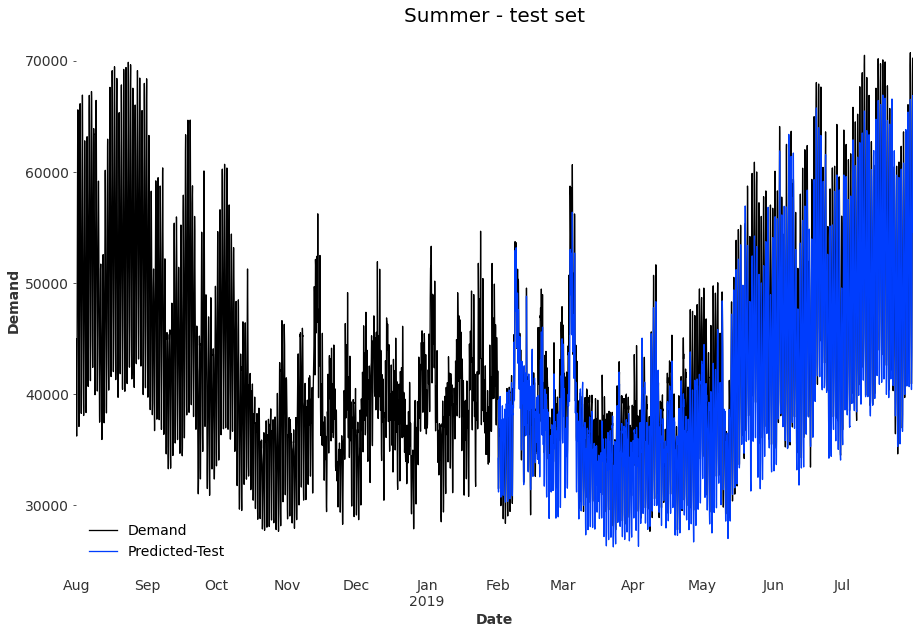

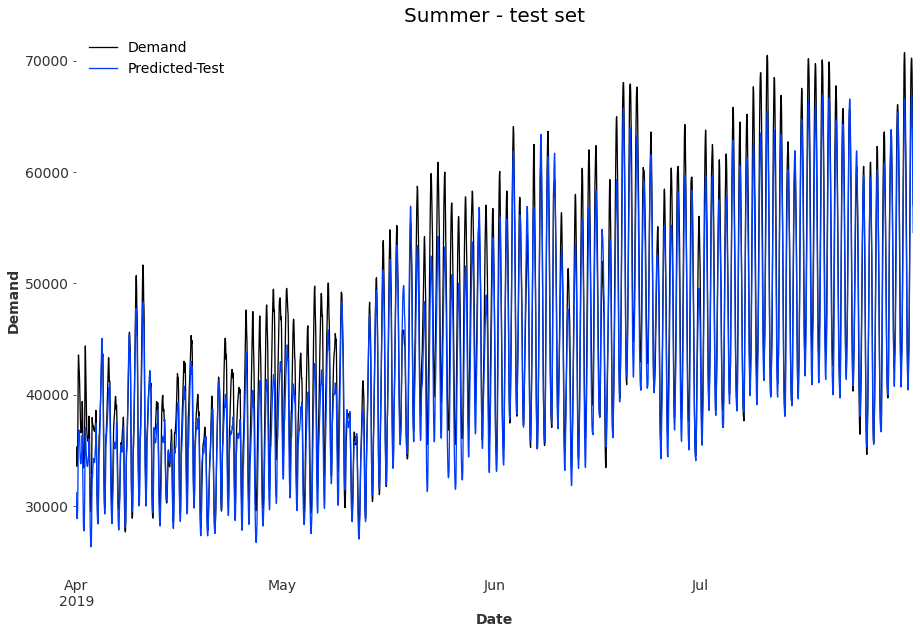

In [30]:
# Plot Fitted Data 
pd.concat([y_01, \
           yhat_Test_RNN_01.rename(columns = {Dependent_Var:'Predicted-Test'})
           ], axis = 1)\
     .loc['2018-08':]\
     .plot()


plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()




pd.concat([y_01, \
           yhat_Test_RNN_01.rename(columns = {Dependent_Var:'Predicted-Test'})
           ], axis = 1)\
     .loc['2019-04':]\
     .plot()


plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()        

In [23]:
print( CalculateR2andR2adj(y_Test_01, yhat_Test_RNN_01, X_Test_sld_01, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_01, yhat_Test_RNN_01),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_01, yhat_Test_RNN_01)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_01, yhat_Test_RNN_01)),2)}' )

R2: 0.9128
R2_adj: 0.9111
(0.9128, 0.9111)

MAE:  2245.09
MAPE: 5.17
RSME: 2782.04


In [ ]:
###################
#%% test '02' model on winter time
###################

In [27]:
# make forecast on test set and rescale data
yhat_Test_RNN_02_sld = Final_Model_02.predict(n = len(y_Test_sld_02_darts)
                                             , future_covariates = X_sld_02_darts).pd_dataframe()


yhat_Test_RNN_02 =  scaler_y_02.inverse_transform(yhat_Test_RNN_02_sld)

yhat_Test_RNN_02 = pd.DataFrame(yhat_Test_RNN_02,\
                                index = yhat_Test_RNN_02_sld.index, columns = yhat_Test_RNN_02_sld.columns)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

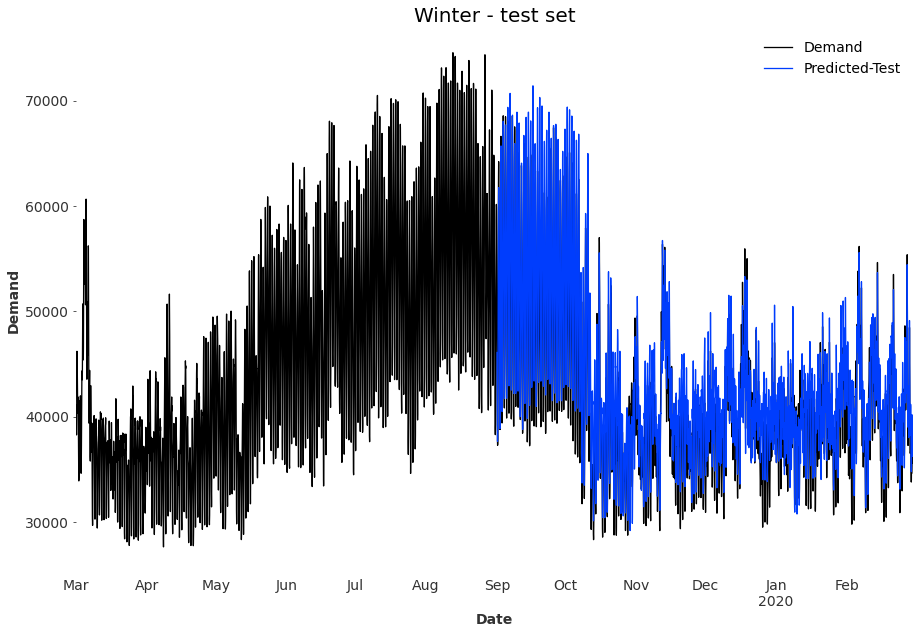

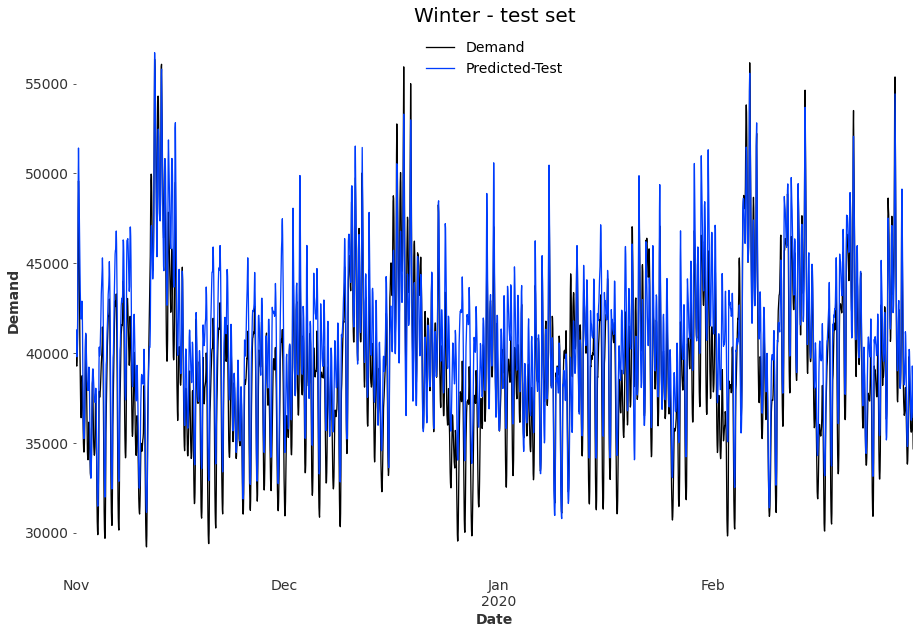

In [28]:
# Plot Fitted Data
pd.concat([y_02, \
           yhat_Test_RNN_02.rename(columns = {Dependent_Var:'Predicted-Test'})
           ], axis = 1)\
     .loc['2019-03':]\
     .plot()


plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()




pd.concat([y_02, \
           yhat_Test_RNN_02.rename(columns = {Dependent_Var:'Predicted-Test'})
           ], axis = 1)\
     .loc['2019-11':]\
     .plot()


plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()        

In [29]:
print( CalculateR2andR2adj(y_Test_02, yhat_Test_RNN_02, X_Test_sld_02, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_02, yhat_Test_RNN_02),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_02, yhat_Test_RNN_02)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_02, yhat_Test_RNN_02)),2)}' )

R2: 0.871
R2_adj: 0.8684
(0.871, 0.8684)

MAE:  2262.17
MAPE: 5.6
RSME: 2802.49
